In [1]:
import numpy as np 
import pandas as pd

## PLOT
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

## Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from collections import Counter

##Split
from sklearn.model_selection import train_test_split

## Modelisation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier as lgb
#import lightgbm as lgb

## Scores
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_recall_fscore_support
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

## feature importance
import shap

## Threshold
from yellowbrick.classifier.threshold import discrimination_threshold

## Export
import pickle
import joblib
## Warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Réduire l'utilisation de la mémoire par le dataframe consolidé

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type to reduce memory usage        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train_set = pd.read_csv('train_set.csv')
test_set = pd.read_csv('test_set.csv')

In [4]:
train_set = reduce_mem_usage(train_set)

Memory usage of dataframe is 593.56 MB
Memory usage after optimization is: 204.99 MB
Decreased by 65.5%


In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 253 entries, PAYMENT_RATE to SK_ID_CURR
dtypes: float16(146), float32(96), float64(1), int16(2), int32(1), int8(7)
memory usage: 205.0 MB


In [6]:
train_set.shape

(307507, 253)

In [7]:
train_set.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
train_len = train_set.shape[0]
train_dataset = train_set[:train_len]
train_ids = train_dataset['SK_ID_CURR']
train_dataset.drop(columns=['SK_ID_CURR'], axis = 1, inplace=True)

In [9]:
# separate training dataset
train_dataset['TARGET'] = train_dataset['TARGET'].astype(int)
target = train_dataset['TARGET']
features = train_dataset.drop(columns=['TARGET'], axis = 1)
print('x_train data shape: ', features.shape)
print('y_train data shape: ', target.shape)

x_train data shape:  (307507, 251)
y_train data shape:  (307507,)


In [10]:
target_sample = target
target_sample.shape

(307507,)

In [11]:
target_sample = target
target_sample.shape

(307507,)

In [12]:
features_sample = features
features_sample.shape

(307507, 251)

# objectif de ce notebook

    Résoudre la problèmatique des 'Imbalanced Data'
    Tester différents modèles de classification et optimiser les hyperparamètres ( avec un GridSearchCV)
    Evaluer les performances avec des scores de classification (AUC et Fbeta, F1 etc.)
    Optimiser le treshold pour avec le moins de 
    Sélectioner et visualiser les caractéristiques de modèle (feature importance et shap)

# preprocessing



Le prétraitement des données est le suivant:

    - Echantillionage du jeu de données (30% test set)
    - Mise à l'échelle des fonctionnalités (Robust scaler(plus fiable vis à vis des outliers))
    - Compléter les données manquantes (imputation médiane)

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(features_sample, target_sample, test_size = 0.3)

In [14]:
# define numerical columns
numeric_attribute = list(features_sample.select_dtypes(exclude=["bool_","object_"]).columns)

In [15]:
# pipeline transformation (imputation, scaling, encoding)
def Preprocessing (numeric):
    numeric_transfs = [('imputer',SimpleImputer(missing_values= np.NAN, strategy= 'median')),('scaler', RobustScaler())]
    numeric_pipeline = Pipeline(numeric_transfs)
    all_transfs = [("numeric",numeric_pipeline,numeric)]
    full_preprocessor = ColumnTransformer(all_transfs, remainder='passthrough')
    return full_preprocessor

In [16]:
# data Transformed
preprocessor_fitted = Preprocessing(numeric_attribute).fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)

In [17]:
pd.DataFrame(X_train).to_csv('X_train.csv',index=False)
pd.DataFrame(y_train).to_csv('y_train.csv',index=False)
pd.DataFrame(X_test).to_csv('X_test.csv',index=False)
pd.DataFrame(y_test).to_csv('y_test.csv',index=False)

In [18]:
X_train.shape

(215254, 251)

In [19]:
X_test.shape

(92253, 251)

In [20]:
#X_train_transformed.shape, X_test_transformed.shape, y_train.shape, y_test.shape

# regression logistique & baseline

In [21]:
#C=10, multi_class="auto", solver="liblinear"

In [22]:
def log_reg(df_X_train, df_y_train, df_y_test, df_X_test):
    
    # make the model with the specified regularization parameter
    log_reg = LogisticRegression(C = 0.0001, max_iter=100)

    # train on the training data
    log_reg.fit(df_X_train, df_y_train)
    
    y_pred = log_reg.predict(df_X_test)

    accuracy = accuracy_score(df_y_test, y_pred)
    
    print("Accuracy: %.2f%%" % (accuracy * 100.0)) 
    
    roc_auc = roc_auc_score(df_y_test, y_pred)
    
    print("roc_auc: %.2f%%" % (roc_auc * 100.0))
    
    fbeta = fbeta_score(df_y_test, y_pred, beta=2)
    
    print("fbeta: %.2f%%" % (fbeta * 100.0))
    
    precision = precision_score(df_y_test, y_pred)
    
    print("precision: %.2f%%" % (precision * 100.0))
    
    f1 = f1_score(df_y_test, y_pred)
    
    print("f1_score: %.2f%%" % (f1 * 100.0))
    
    recall = recall_score(df_y_test, y_pred)
    
    print("recall_score: %.2f%%" % (recall * 100.0))

    
    # make predictions
    log_reg_pred = log_reg.predict_proba(df_X_test)[:, 1]
    
    return log_reg_pred

In [23]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''function will make a pretty plot of 
  an sklearn confusion matrix using a Seaborn heatmap visualization + ROC curve'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['true neg', 'false pos', 'false neg', 'true pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %auc_score_lgb)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend()

In [24]:
def save_results(df_res, df_pred, new_col, df_index):

    df_pred_lr = pd.DataFrame(df_pred, columns=[new_col], index=df_index.index)

    df_res = pd.concat([df_res, df_pred_lr], sort=False, axis=1)
    
    return df_res

In [25]:
def transform_treshold(df, tresh):
    
    new_df = (df >= tresh).astype("int")
    
    return new_df

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# we create the results dataframe
df_results_base = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# we launch the predictions
log_reg_pred = log_reg(X_train_transformed, y_train, y_test, X_test_transformed)

# save the results
df_results_base = save_results(df_results_base, log_reg_pred, "y_pred_lr", y_test)

# we "binarize" the probabilities with a treshold set to 0.5
# for example, for a treshold of 0.5, if the probability is lower the value will be 0. Otherwise it will be 1.
# and we concatenate the data to our array of results
df_results_base["y_pred_lr_bin"] = transform_treshold(df_results_base["y_pred_lr"], 0.5)

display(df_results_base.head())
print(df_results_base.shape)
print(classification_report(y_test, df_results_base["y_pred_lr_bin"]))

Accuracy: 56.46%
roc_auc: 50.14%
fbeta: 22.90%
precision: 8.03%
f1_score: 13.51%
recall_score: 42.62%


,y_true,y_pred_lr,y_pred_lr_bin
296526,0,0.493337,0
109743,0,0.500000,1
277593,0,0.500000,1
248433,0,0.221805,0
57955,1,0.044838,0


(92253, 3)
              precision    recall  f1-score   support

           0       0.92      0.58      0.71     84891
           1       0.08      0.43      0.14      7362

    accuracy                           0.56     92253
   macro avg       0.50      0.50      0.42     92253
weighted avg       0.85      0.56      0.66     92253



# Accuracy, Precision, Recall, F1 score


- L'accuracy : l'accuracy ne signifit pas grand chose pour les problemes de classification binaire
- La précision : ce coefficient détermine que, quand le classifieur déclare que la prédiction est un 1, il a raison à X%.
- Le rappel : ce coefficient détermine le pourcentage de détection des 1 du classifieur
- Le F1-score : ce coefficient est une moyenne de la précision et du rappel

Les premiers résultats  montre un déséquilibre entre la précision de la target 0 (0.92) et la target 1 (0.08) 
Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1 (1= défaut de paiement)
Le feature engineering précedement fait n'a pas tellement contribuer a un amélioration des scores

Il serait donc intéressant d'essayer l'oversampling/undersampling pour ajuster la distribution de classe de manière égalitaire 50%-50%

- l'under sampling, enlève des individus de la classe majoritaire
- l'over sampling, rajoute des individus dans la classe minoritaire

# matrice de confusion

Affiche les prédictions correctes et incorrectes pour chaque classe

In [27]:
def aff_confusion_matrix(df_true, df_pred):

    conf_mat = confusion_matrix(df_true, df_pred)

    print('confusion matrix:\n', conf_mat)

    labels = ['classe 0', 'classe 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('predicted')
    plt.ylabel('expected')
    plt.show()

La matrice de confusion permet d'évaluer l'exactitude d'une classification.

Les individus dont la valeur cible réelle est 0 et dont la prédiction est 0 sont les 'True Negatives' dits aussi 'TN'

Les individus dont la valeur cible réelle est 0 alors que la prédiction est 1 sont les 'False Negatives' appelés aussi 'FN'

Les individus dont la valeur cible réelle est 1 alors que la prédiction est 0 sont les 'False Positives' appelés aussi 'FP'

Les individus dont la valeur cible réelle est 1 et dont la prédiction est 1 sont les 'True Positives' appelés aussi 'TP'

confusion matrix:
 [[48949 35942]
 [ 4224  3138]]


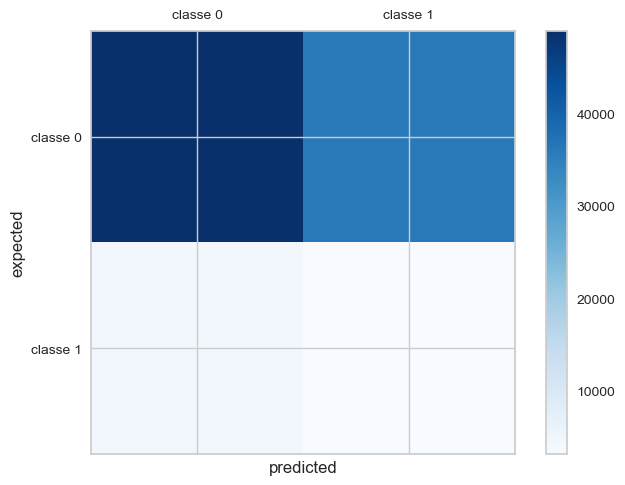

In [28]:
from sklearn.metrics import confusion_matrix

aff_confusion_matrix(df_results_base["y_true"], df_results_base["y_pred_lr_bin"])

# resampling

- Le sous-échantillonnage aléatoire (random undersampling) des observations majoritaires : on retire aléatoirement des observations majoritaires
- Le sur-échantillonnage aléatoire (random oversampling) des observations minoritaires : on tire au hasard des individus minoritaires que l’on rajoute aux données
- Le sur-échantillonnage synthétique (SMOTE pour Synthetic Minority Oversampling Technique) produit des observations minoritaires ressemblantes mais distinctes de celles déjà existantes

- 'auto': equivalent to 'not minority' =rééchantillonner toutes les classes sauf la classe minoritaire

In [29]:
percent0 = (y_train.value_counts()[0] / y_train.shape) * 100
percent1 = (y_train.value_counts()[1] / y_train.shape) * 100

print("nombre d'individus pour la classe 0 :", y_train.value_counts()[0], ". soit", percent0, "% de la population.")
print("nombre d'individus pour la classe 1 :", y_train.value_counts()[1], ". soit", percent1, "% de la population.")

nombre d'individus pour la classe 0 : 197791 . soit [91.88725877] % de la population.
nombre d'individus pour la classe 1 : 17463 . soit [8.11274123] % de la population.


In [30]:
from imblearn.under_sampling  import RandomUnderSampler

print("resampling")
smt = RandomUnderSampler()
X_smt, y_smt = smt.fit_resample(X_train_transformed, y_train)

print('original dataset shape %s' % Counter(y_train))
print('resampled dataset shape %s' % Counter(y_smt))

resampling
original dataset shape Counter({0: 197791, 1: 17463})
resampled dataset shape Counter({0: 17463, 1: 17463})


classe 0: 17463
classe 1: 17463
proportion: 1.0 : 1


([<matplotlib.patches.Wedge at 0x1c18c0120b0>,
 [Text(-1.1, 1.3471114790620887e-16, 'classe 0'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'classe 1')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

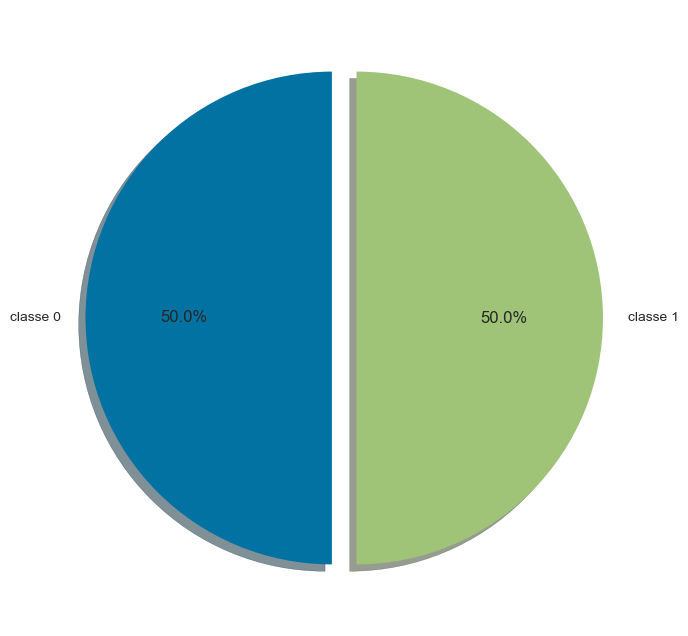

In [31]:
target_count = y_smt.value_counts()
print('classe 0:', target_count[0])
print('classe 1:', target_count[1])
print('proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1], labels=["classe 0", "classe 1"], autopct='%1.1f%%',
        shadow=True, startangle=90)

In [ ]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_smt, y_smt)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
Best: 0.582346 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.582145 (0.009070) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.543950 (0.009215) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.566198 (0.010931) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.582021 (0.009009) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.544437 (0.009022) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.567371 (0.010336) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.582346 (0.008499) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.544122 (0.009121) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.566474 (0.010039) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.582117 (0.009052) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.544399 (0.008827) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.564078 (0.009342) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.582088 (0.008292) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.544800 (0.008795) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.566178 (0.009317) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

# regression logistique & baseline avec SMT

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# we create the results dataframe
df_results_base2 = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# we launch the predictions
log_reg_pred = log_reg(X_smt, y_smt, y_test, X_test_transformed)

# save the results
df_results_base2 = save_results(df_results_base2, log_reg_pred, "y_pred_lr", y_test)

# we "binarize" the probabilities with a treshold set to 0.5
# for example, for a treshold of 0.5, if the probability is lower the value will be 0. Otherwise it will be 1.
# and we concatenate the data to our array of results
df_results_base2["y_pred_lr_bin"] = transform_treshold(df_results_base2["y_pred_lr"], 0.5)

display(df_results_base2.head())
print(df_results_base2.shape)
print(classification_report(y_test, df_results_base2["y_pred_lr_bin"]))

In [ ]:
aff_confusion_matrix(df_results_base2["y_true"], df_results_base2["y_pred_lr_bin"])

FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive
Perte réelle si le crédit client accepté se transforme en défaut de paiement

FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative
Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé

# Autre model et otptimisation des hyperparametres

# lightGBM

les modeles de boosting (lgbm) sont plus sujets au surentrainement et rapide. Ils offrent une précision beaucoup plus élevée et sont plus comptabiles avec les grands ensembles de données.
De plus, c'est Le model le plus récompenser sur Kaggle au sujet de la classifcation binaire.
Essayons-le

In [ ]:
def model_optimisation (classifier, param_grid, scoring, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=51)
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid,scoring='roc_auc', cv=cv)
    grid_search.fit(X, y)
    return grid_search.best_score_,grid_search.best_params_,grid_search.best_estimator_

In [ ]:
#    'num_leaves': [15, 31, 63],
#    'max_depth': (6, 10, 30),
#    'num_iterations': [50, 100, 200],
#    'min_data_in_leaf': [10, 20, 40],
#    'learning_rate': [0.05, 0.1, 0.2]

In [ ]:
### Light GBM
light_gbm_params = {
        'max_depth': (6, 10),
        'num_leaves':(15, 20),
        #'min_data_in_leaf': (230, 250),
               }

scoring = make_scorer(roc_auc_score)
LGBM = lgb(random_state=51, n_estimators=3000)

In [ ]:
#lgbm_model_score, lgbm_model_param, lgbm_model_estimator = model_optimisation(LGBM, light_gbm_params, scoring, X_smt, y_smt)

In [ ]:
#lgbm_model_score

In [ ]:
#lgbm_model_param

In [ ]:
#lgbm_model_estimator

In [ ]:
#max_depth=10, min_data_in_leaf=230, n_estimators=10000, num_leaves=20, random_state=51

In [ ]:
#is_unbalance=False, learning_rate=0.05, max_depth=10, min_data_in_leaf=40, n_estimators=10000, num_iterations=200, num_leaves=63, random_state=51

In [ ]:
df_results = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# create the model
clf_lgb = lgb(n_estimators=3000, learning_rate=0.05, max_depth=10, min_data_in_leaf=40, num_iterations=200, num_leaves=63, random_state=51)

# train on the training data
clf_lgb.fit(X_train, y_train)

# make predictions
# make sure to select the second column only

lgb_pred_smoted = clf_lgb.predict_proba(X_test)[:, 1]



df_results = save_results(df_results, lgb_pred_smoted, "y_pred_lgb_smoted", y_test)
df_results["y_pred_lgb_smoted_bin"] = transform_treshold(df_results["y_pred_lgb_smoted"], 0.5)
# submission dataframe
df_results["y_pred_lgb_smoted"] = lgb_pred_smoted
df_results.head()

In [ ]:
auc_score_lgb = roc_auc_score(y_test, lgb_pred_smoted)

In [ ]:
auc_score_lgb

In [ ]:
#grid_search.best_estimator_

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
from sklearn import metrics



df_results = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# create the model
clf_lgb = lgb(n_estimators=3000, learning_rate=0.05, max_depth=10, min_data_in_leaf=40, num_iterations=200, num_leaves=63, random_state=51)

# train on the training data
clf_lgb.fit(X_train, y_train)

# make predictions
# make sure to select the second column only

lgb_pred_smoted = clf_lgb.predict_proba(X_test)[:, 1]

df_results = save_results(df_results, lgb_pred_smoted, "y_pred_lgb_smoted", y_test)
df_results["y_pred_lgb_smoted_bin"] = transform_treshold(df_results["y_pred_lgb_smoted"], 0.43)
# submission dataframe
df_results["y_pred_lgb_smoted"] = lgb_pred_smoted




fpr, tpr, thresholds = metrics.roc_curve(y_test, df_results["y_pred_lgb_smoted"])
precision_, recall_, thresh_ = precision_recall_curve(y_test, df_results["y_pred_lgb_smoted"])

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)



tn, fp, fn, tp = confusion_matrix(y_test, df_results["y_pred_lgb_smoted_bin"]).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
som=tn+fp+fn+tp
conf_mat = [[tn/som*100,fp/som*100],[fn/som*100,tp/som*100]]

auc = metrics.roc_auc_score(y_test, lgb_pred_smoted)
recall = metrics.recall_score(y_test, df_results["y_pred_lgb_smoted_bin"] )
precision = metrics.precision_score(y_test, df_results["y_pred_lgb_smoted_bin"] )
f1 = metrics.f1_score(y_test, df_results["y_pred_lgb_smoted_bin"] )


######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, annot=True, cbar=True)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn import metrics


df_results = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# create the model
clf_lgb = lgb(n_estimators=3000, learning_rate=0.05, max_depth=10, min_data_in_leaf=40, num_iterations=200, num_leaves=63, random_state=51)

# Train on the training data
clf_lgb.fit(X_smt, y_smt)

# make predictions
# make sure to select the second column only

lgb_pred_smoted = clf_lgb.predict_proba(X_test)[:, 1]

df_results = save_results(df_results, lgb_pred_smoted, "y_pred_lgb_smoted", y_test)
df_results["y_pred_lgb_smoted_bin"] = transform_treshold(df_results["y_pred_lgb_smoted"], 0.43)
# submission dataframe
df_results["y_pred_lgb_smoted"] = lgb_pred_smoted




fpr, tpr, thresholds = metrics.roc_curve(y_test, df_results["y_pred_lgb_smoted"])
precision_, recall_, thresh_ = precision_recall_curve(y_test, df_results["y_pred_lgb_smoted"])

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)



tn, fp, fn, tp = confusion_matrix(y_test, df_results["y_pred_lgb_smoted_bin"]).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
som=tn+fp+fn+tp
conf_mat = [[tn/som*100,fp/som*100],[fn/som*100,tp/som*100]]

auc = metrics.roc_auc_score(y_test, lgb_pred_smoted)
recall = metrics.recall_score(y_test, df_results["y_pred_lgb_smoted_bin"] )
precision = metrics.precision_score(y_test, df_results["y_pred_lgb_smoted_bin"] )
f1 = metrics.f1_score(y_test, df_results["y_pred_lgb_smoted_bin"] )


######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, annot=True, cbar=True)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn import metrics



df_results = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# create the model
clf_lgb = lgb(class_weight = 'balanced', n_estimators=3000, learning_rate=0.05, max_depth=10, min_data_in_leaf=40, num_iterations=200, num_leaves=63, random_state=51)

# train on the training data
clf_lgb.fit(X_train, y_train)

# make predictions
# make sure to select the second column only

lgb_pred = clf_lgb.predict_proba(X_test)[:, 1]

df_results = save_results(df_results, lgb_pred, "y_pred_lgb", y_test)
df_results["y_pred_lgb_bin"] = transform_treshold(df_results["y_pred_lgb"], 0.43)
# submission dataframe
df_results["y_pred_lgb"] = lgb_pred_smoted




fpr, tpr, thresholds = metrics.roc_curve(y_test, df_results["y_pred_lgb"])
precision_, recall_, thresh_ = precision_recall_curve(y_test, df_results["y_pred_lgb"])

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)



tn, fp, fn, tp = confusion_matrix(y_test, df_results["y_pred_lgb_bin"]).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
som=tn+fp+fn+tp
conf_mat = [[tn/som*100,fp/som*100],[fn/som*100,tp/som*100]]

auc = metrics.roc_auc_score(y_test, lgb_pred_smoted)
recall = metrics.recall_score(y_test, df_results["y_pred_lgb_bin"] )
precision = metrics.precision_score(y_test, df_results["y_pred_lgb_bin"] )
f1 = metrics.f1_score(y_test, df_results["y_pred_lgb_bin"] )


######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, annot=True, cbar=True)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

# save the model
filename = 'classifier_lgbm_model.sav'
pickle.dump(clf_lgb, open(filename, 'wb'))

# save the preprocessor
filename = 'preprocessor.sav'
pickle.dump(preprocessor_fitted, open(filename, 'wb'))

data_export = train_dataset.iloc[0:18000].copy()
data_export['SK_ID_CURR']=train_ids[0:18000]
data_export['prediction']=df_results["y_pred_lgb_bin"]
data_export['pred_prob']=df_results["y_pred_lgb"]
data_export.to_csv("dataset_exported.csv",index=False)

data_export.info()

application_train = pd.read_csv('data/application_train.csv')
application_test = pd.read_csv('data/application_test.csv')

data_export4 = application_train.iloc[0:18000].copy()
data_export4.to_csv("application_train.csv",index=False)

data_export5 = application_test.iloc[0:18000].copy()
data_export5.to_csv("application_test.csv",index=False)

y_pred_test_export = pd.DataFrame()
y_pred_test_export['y_test'] = y_test
y_pred_test_export['y_probability'] = df_results["y_pred_lgb"]
y_pred_test_export['y_predicted'] = df_results["y_pred_lgb_bin"]
y_pred_test_export.to_csv("y_pred_test_export.csv",index=False)

y_pred_test_export.info()

data_export1 = test_set.iloc[0:18000].copy()
data_export1.to_csv("test_set_git.csv",index=False)

data_export2 = train_set.iloc[0:18000].copy()
data_export2.to_csv("train_set_git.csv",index=False)

df_final = pd.read_csv('df_final.csv')
data_export3 = df_final.iloc[0:18000].copy()
data_export3.to_csv("df_final_git.csv",index=False)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn import metrics



df_results = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# create the model
clf_lgb = lgb(class_weight = 'balanced', n_estimators=3000, learning_rate=0.05, max_depth=10, min_data_in_leaf=40, num_iterations=200, num_leaves=63, random_state=51)

# train on the training data
clf_lgb.fit(X_smt, y_smt)

# make predictions
# make sure to select the second column only

lgb_pred_smoted = clf_lgb.predict_proba(X_test)[:, 1]

df_results = save_results(df_results, lgb_pred_smoted, "y_pred_lgb_smoted", y_test)
df_results["y_pred_lgb_smoted_bin"] = transform_treshold(df_results["y_pred_lgb_smoted"], 0.43)
# Submission dataframe
df_results["y_pred_lgb_smoted"] = lgb_pred_smoted




fpr, tpr, thresholds = metrics.roc_curve(y_test, df_results["y_pred_lgb_smoted"])
precision_, recall_, thresh_ = precision_recall_curve(y_test, df_results["y_pred_lgb_smoted"])

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)



tn, fp, fn, tp = confusion_matrix(y_test, df_results["y_pred_lgb_smoted_bin"]).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
som=tn+fp+fn+tp
conf_mat = [[tn/som*100,fp/som*100],[fn/som*100,tp/som*100]]

auc = metrics.roc_auc_score(y_test, lgb_pred_smoted)
recall = metrics.recall_score(y_test, df_results["y_pred_lgb_smoted_bin"] )
precision = metrics.precision_score(y_test, df_results["y_pred_lgb_smoted_bin"] )
f1 = metrics.f1_score(y_test, df_results["y_pred_lgb_smoted_bin"] )


######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, annot=True, cbar=True)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

# Courbe Receiver Operating Characteristic (ROC) et Area Under the Curve (AUC)

Le roc curve résume les performances d'un classificateur sur tous les seuils possibles. Il est généré en traçant le taux de vrais positifs (axe des y) par rapport au taux de faux positifs (axe des x)

La courbe ROC est un outil utilisé avec les classifieurs binaires. Elle croise le taux de TP avec le taux de FP. Le taux de FP est le pourcentage d'observations négatives qui sont incorrectement classées comme positives. Il est égal à 1 moins le taux de TN, qui est le pourcentage d'observations négatives qui sont correctement classées comme négatives
Les classificateurs qui donnent des courbes plus proches du coin supérieur gauche indiquent une meilleure performance

Le score AUC est une façon de comparer les classificateurs, un incateur chiffré de la courbe. Un classificateur parfait a une aire sous la courbe ROC égale à 1, tandis qu'un classificateur aléatoire a une ROC AUC de 0.5

In [ ]:
df_results["y_pred_lgb_smoted_bin"] = transform_treshold(df_results["y_pred_lgb_smoted"], 0.43)
df_results.head()

In [ ]:
cf_matrix_roc_auc(clf_lgb, df_results["y_true"], df_results["y_pred_lgb_smoted_bin"], df_results["y_pred_lgb_smoted"], feature_importances=None)

# Matrice de confusion et optimisation du seuil
 - minimiser les FN 
 - minimiser les FP
 - maximiser Recall 
 - maximiser Precision
 - Le but est d'éviter les clients avec un fort risque de défaut et donc une perte financière
 - les défaillants forment la classe positive,
 - les non-défaillants forment la classe négative
 - Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise
 - Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités FP et FN

In [ ]:
#RFC = RandomForestClassifier(criterion='entropy', max_features='auto', max_depth=4, n_estimators=160)

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

model = RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=140)
visualizer = DiscriminationThreshold(model)

visualizer.fit(X_smt, y_smt)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

model = RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=140)
visualizer = DiscriminationThreshold(model, fbeta=5)

visualizer.fit(X_smt, y_smt)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

model = RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=140)
visualizer = DiscriminationThreshold(model, fbeta=10)

visualizer.fit(X_smt, y_smt)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [5]:
threshold=0.52
joblib.dump(threshold, './threshold.joblib')

['./threshold.joblib']

# fonction coût ou fBeta score

La mesure Fbeta est une métrique à score unique configurable pour évaluer un model de classification binaire basé sur les prédictions faites pour la classe positive

Elle est calculé en utilisant la précision et le rappel:

- la précision est une métrique qui calcule le pourcentage de prédictions correctes pour la classe positive
- le recall calcule le pourcentage de prédictions correctes pour la classe positive parmi toutes les prédictions positives qui pourraient être faites
- maximiser la précision minimisera les erreurs de faux positifs, tandis que maximiser le rappel minimisera les erreurs de faux négatifs

La mesure Fbeta est une généralisation de la mesure F qui ajoute un paramètre de configuration appelé bêta. Une valeur bêta par défaut est 1,0, qui est identique a la F-mesure. Une valeur bêta plus petite, telle que 0,5, donnera plus de poids a la précision et moins au rappel, tandis qu'une valeur bêta plus élevée, telle que 2 ou 3, donne moins de poids a la précision et plus de poids au rappel dans le calcul du score

Dans le but de notre projet, on s'interesse a maximiser le rappel donc minimiser les erreurs de faux négatifs.==> beta=2 ou 3

# SHAP
- La méthode SHAP (SHapley Additive exPlanations) consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles

In [ ]:
explainer = shap.TreeExplainer(clf_lgb)
shap_values = explainer.shap_values(X_test)
# Summary plot
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values[1], X_test, show=False)

In [ ]:
explainer = shap.Explainer(clf_lgb, X_train)
shap_values = explainer(X_train, check_additivity=False)

In [ ]:
shap.plots.bar(shap_values, max_display=36)

In [ ]:
shap.plots.beeswarm(shap_values)

conclusion
lightGBM donne des résultats moyennement correct
Nous allons maintenant nous travailler sur le dashboard et afficher les informations utiles pour le client

# Dummy classifiers

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc

In [ ]:
dclf = DummyClassifier(strategy="most_frequent")
dclf.fit(X_train, y_train)

In [ ]:
y_test_pred_proba = dclf.predict_proba(X_test)
print(y_test_pred_proba)
print("total :", y_test_pred_proba.sum())

In [ ]:
y_train_pred_proba = dclf.predict_proba(X_train)
fpr, tpr, thr = roc_curve(y_train, y_train_pred_proba[:, 1])

In [ ]:
plt.figure()
plt.plot(
    fpr,
    tpr,
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("courbe ROC train-set", fontsize=14)
plt.legend()
plt.show()

In [ ]:
fbetascore, precision 
api flask > streamlit